# **Recommender Systems**

A common problem in marketing-oriented data analysis is producing recommendations of some sort. 

* Netflix recommends movies you might want to watch. 

* Amazon recommends products you might want to buy. 

* Twitter recommends users you might want to follow. 

**Q1:** How do we suggest new interests or products to our customers?

**Q2:** How can we build a recommender system?



## A toy example

Let us consider the following user interests toy dataset.
Our goal is recommending new interests to the users based on their existing interests.


In [1]:
# Our data set is a python list containing users interests.
# Each element of the list contains the interests of a specific user.

users_interests = [
        ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
        ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
        ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
        ["R", "Python", "statistics", "regression", "probability"],
        ["machine learning", "regression", "decision trees", "libsvm"],
        ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
        ["statistics", "probability", "mathematics", "theory"],
        ["machine learning", "scikit-learn", "Mahout", "neural networks"],
        ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
        ["Hadoop", "Java", "MapReduce", "Big Data"],
        ["statistics", "R", "statsmodels"],
        ["C++", "deep learning", "artificial intelligence", "probability"],
        ["pandas", "R", "Python"],
        ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
        ["libsvm", "regression", "support vector machines"]
]

### Approach 1: recommending what’s popular

One easy approach is to simply recommend what’s popular. 

* We do not take into account the current specified interests of the user.
* We do filter current user's interests before suggesting new interests.
* Popularity based recommendations can be a good strategy for targeting new customers, those for whom we do not have a history of interests.




**Q1:** How do we recommend popular interests?

In [2]:
from collections import Counter

# we "flatten" the nested list of interests
all_interests = []
for user_interests in users_interests:
    for interest in user_interests:
        all_interests.append(interest)
        
# we count how many times each interest has been selected by users
interest_counts = Counter(all_interests)

# we take the list of all unique interests in the dataset
unique_interests = list(interest_counts.keys())

# we order them from the most common to the least common.
popular_interests = interest_counts.most_common()

# ** NOTE **
#
# A Counter is a dict subclass for counting hashable objects. 
# It is a collection where elements are stored as dictionary 
# keys and their counts are stored as dictionary values. 
# Counts are allowed to be any integer value including zero or 
# negative counts.
# 
# Counter([iterable-or-mapping])
#   Counter iterates over the input elements and produces a 
#   dictionary with the elements as keys and their frequency 
#   as values. 
#
# most_common([n])
#   Return a list of the n most common elements and their 
#   counts from the most common to the least common.
#
# ** NOTE **

popular_interests[:5]

[('Python', 4), ('R', 4), ('Big Data', 3), ('HBase', 3), ('Java', 3)]

At least, we suggest to the users the most popular interests *that they are not already interested in*.

To this end, we write a function that takes as input the user's interests and returns as output the recommendations.

In [3]:
# The function takes as input a list of user's interests and
# returns a list of suggestions of length <max_results>

def most_popular_new_interests(user_interests, max_results=5): 
    i = 0
    suggestions = []
    for interest, frequency in popular_interests:
        if interest not in user_interests:
            suggestions.append(interest)
            i += 1
            if i == max_results:
                break
    return suggestions

In [4]:
# We make recommendations for user 0

print(f"User's interests: {users_interests[0]}\n")
print(f"Suggestions:")
most_popular_new_interests(users_interests[0], 5)

User's interests: ['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']

Suggestions:


['Python', 'R', 'statistics', 'regression', 'probability']

### Approach 2: Collaborative Filtering

We want to recommend new interests to users based on their currently specified interests.

#### User-Based Collaborative Filtering ####

One way of taking a user’s interests into account is to look for users who are somehow ***similar*** to them, and then suggest the things that those users are interested in.

- **users** are defined by their **lists of interests**
- **similarity between users** means **similarity between interest lists**
- we recommend interests that are **popular among similar users**

#### Item-Based Collaborative Filtering ####

Another way of taking a user’s interests into account is to suggest new interests that are somehow ***similar*** to the interests the user already has.

- **items** are defined by the **users interested in them**
- **similarity between items** means **similarity between lists of users**
- we recommend **interests that are overall similar** to the user's interests

**Question:** How exactly do we represent users/items and measure *similarity* between data that are non-numeric?

**Answer: Embedding of nonnumeric data**

We have seen in previous lectures that we can measure similarity based on the distance on some *metric space*.
This general idea can be applied even to **nonnumeric data**.

### User-Based Collaborative Filtering

In our toy example:
* we are given a data set containing users interests
* we want to find users that are *similar* according to their interests

#### Representing users as *one-hot vectors*

We represent users with vectors of 0s and 1s:
* the length of the vector is the number of possible interests
* the $i$th element of the vector is 1 if the user is interested in the $i$th item, 0 otherwise

To this end, we transform the dataset as follows:

In [5]:
import pandas as pd

# build dictionary of columns
d = {c:[] for c in unique_interests}
for user in users_interests:
    for c in unique_interests:
        if c in user:
            d[c].append(1)
        else:
            d[c].append(0)

# transform in a dataframe
users_df = pd.DataFrame(d)

users_df.head()

Hadoop  Big Data  HBase  Java  Spark  Storm  Cassandra  NoSQL  MongoDB  \
0       1         1      1     1      1      1          1      0        0   
1       0         0      1     0      0      0          1      1        1   
2       0         0      0     0      0      0          0      0        0   
3       0         0      0     0      0      0          0      0        0   
4       0         0      0     0      0      0          0      0        0   

   Postgres  ...  mathematics  theory  Mahout  neural networks  deep learning  \
0         0  ...            0       0       0                0              0   
1         1  ...            0       0       0                0              0   
2         0  ...            0       0       0                0              0   
3         0  ...            0       0       0                0              0   
4         0  ...            0       0       0                0              0   

   artificial intelligence  MapReduce  databases  MySQL  \
0                        0          0          0      0   
1                        0          0          0      0   
2                        0          0          0      0   
3                        0          0          0      0   
4                        0          0          0      0   

   support vector machines  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  

[5 rows x 36 columns]

We can now extract the vectors as a numpy array:

In [6]:
# extract all vectors as a #users x #interests matrix
users_array = users_df.to_numpy()

Now, we define the cosine similarity:

In [7]:
import math

def dot(a, b):
    return sum(a_i * b_i for a_i, b_i in zip(a, b))

def cosine_similarity(a, b):
    return dot(a, b) / math.sqrt(dot(a, a) * dot(b, b))

We compute the pairwise similarity, as a #users $\times$ #users matrix:

In [8]:
from sklearn.metrics import pairwise_distances

sim_mat = pairwise_distances(users_array, metric=cosine_similarity)

In [9]:
import seaborn as sns

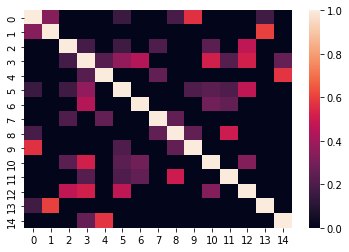

In [10]:
sns.heatmap(sim_mat)

#### **Recommendations**

**Q:** How do we use pairwise similarities to make recommendations for user $u$?

- We find the $m$ most similar users $v_1,\ldots,v_m$ to $u$ (if we want to consider all users, we set $m=\mathrm{\#users}$)
- For each interest $I$:
    - we assign to $I$ a score equal to the sum of the similarity between $u$ and all users $v_k$ that have interest $I$
- We suggest to $u$ the interests based on this score, i.e., based on the **total similarity** of similar users that have those interests.

In [11]:
from collections import defaultdict

def user_based_suggestions(user_id, users_interests, sim_matrix, n_other_users=10, include_current_interests=False): 
    # empty dict, where each value is automatically initialized to 0.0
    suggestions = defaultdict(float)
    
    # sort other users by similarity with 
    most_similar = sim_matrix[user_id].argsort()[::-1]
    
    # ignore the user himself
    most_similar = most_similar[1:]
    
    # consider only the most similar users
    if n_other_users<len(most_similar):
        most_similar = most_similar[:n_other_users]
        
    # we only consider interests of the most similar users
    # each such interest has a score equal to the sum of the similarities of those users (if they have that interest)
    for v in most_similar:
        for interest in users_interests[v]:
            suggestions[interest] += sim_matrix[user_id][v]

    # possibly, exclude interests that the user already has
    if not include_current_interests:
        for interest in users_interests[user_id]:
            if interest in suggestions:
                del(suggestions[interest])
            
    # sort the suggestion by total score
    suggestions = sorted(suggestions.items(), key=lambda s: s[1], reverse=True)  

    return suggestions
    


We are ready to suggest new interests to our users.

In [12]:
# Let's see what we suggest to user 0

user_based_suggestions(0, users_interests, sim_mat)[:5]

[('MapReduce', 0.5669467095138409),
 ('MongoDB', 0.50709255283711),
 ('Postgres', 0.50709255283711),
 ('NoSQL', 0.3380617018914066),
 ('neural networks', 0.1889822365046136)]

### Item-Based Collaborative Filtering

For item-based filtering, we proceed in a similar way.

#### Interest vectors

We need **interest vectors**, instead of users vectors.
The principle is the same:
- vectors have one entry for each user in the dataset
- entry $j$ is 1 if user $j$ has that interest, 0 otherwise

Actually, we can just **transpose** the user matrix we already built: the columns of the user matrix will be the rows of the interests matrix


In [13]:
interests_array = users_array.T

# Example
#
# interests_array[0] corresponds to users interested in Big Data.
# since the only users interested in Big Data are 0, 8, and 9, Big Data must be represented as:
#
#   [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
#

print(f"Interest: {unique_interests[0]}" )
print(f"row: {interests_array[0]}" )


Interest: Hadoop
row: [1 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


#### Exercise:

Compute the `interests_array` from scratch, using an analogous procedure to the one we used to build the `users_array`.

We compute the pairwise similarity, as a #interests $\times$ #interests matrix:

Text(0.5, 1.0, 'interest similarity')

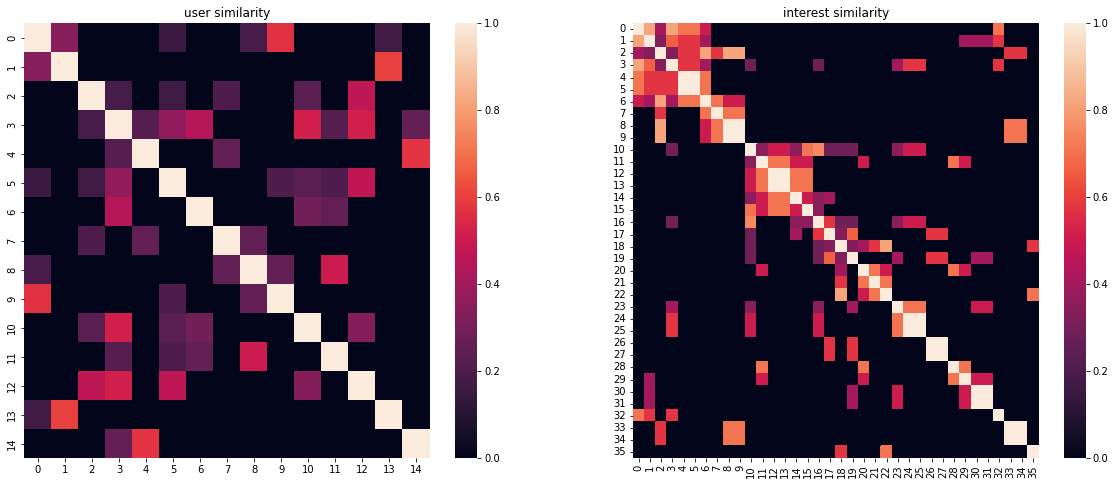

In [14]:
interests_sim_mat = pairwise_distances(interests_array, metric=cosine_similarity)


# let us compare the two similarity matrices
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

sns.heatmap(sim_mat, ax=ax1, )
ax1.set_title('user similarity')
sns.heatmap(interests_sim_mat, ax=ax2)
ax2.set_title('interest similarity')

#### **Recommendations**

**Q:** How do we use pairwise similarities to make recommendations for user $u$?

- For each item $I$ that $u$ is not already interested in:
    - we get the similarity of $I$ with all items $u$ is interested in
    - we assign to $I$ a score equal to the sum of such similarities
- we suggest to $u$ the interests having the maximum **total similarity score**

In [15]:
def item_based_suggestions(user_id, user_vector, interest_list, sim_matrix, include_current_interests=False): 
    
    # select only the similarity with respect to the user's interests
    # user_vector specifies that user's interests, i.e., which rows of sim_matrix we should consider
    sub_matrix = sim_matrix[user_vector.astype(bool)]
    # the sum of each column of the submatrix is the total similarity of each interest with that user's interests
    total_similarity = sub_matrix.sum(axis=0)
    
    # build a dictionary from interest names and total similarities
    suggestions = {interest:similarity for interest,similarity in zip(interest_list,total_similarity)}
    
    # possibly, exclude interests that the user already has
    if not include_current_interests:
        for i in range(len(interest_list)):
            if user_vector[i]>0 and interest_list[i] in suggestions:
                del(suggestions[interest_list[i]])

    # sort the suggestion by total score
    suggestions = sorted(suggestions.items(), key=lambda s: s[1], reverse=True)  

    return suggestions
    


We are ready to suggest new interests to our users.

In [16]:
# Let's see what we suggest to user 0

# the one-hot vector for user 0 is the 0th column of the interest array
user_vector = interests_array[:,0]

item_based_suggestions(0, user_vector, unique_interests, interests_sim_mat)[:5]

[('MapReduce', 1.861807319565799),
 ('MongoDB', 1.3164965809277263),
 ('Postgres', 1.3164965809277263),
 ('NoSQL', 1.2844570503761732),
 ('Haskell', 0.5773502691896258)]

_______
_______

## **Case Study: Amazon - Ratings (Beauty Products)**

Let us now implement what we have seen before with a real dataset.

You can find the data set [here](https://www.kaggle.com/datasets/skillsmuggler/amazon-ratings). 

#### About the dataset

This is a dataset related to over 2 Million customer reviews and ratings of Beauty related products sold on their website.

It contains

* the unique **UserId** (Customer Identification),
* the product **ASIN** (Amazon's unique product identification code for each product),
* **Ratings** (ranging from 1-5 based on customer satisfaction) and
* the **Timestamp** of the rating (in UNIX time)

If you want to know which are the products in the data set you can check this [website](https://amazon-asin.com)

In [17]:
import pandas as pd

amazon = pd.read_csv('ratings_Beauty.csv')
amazon = amazon.dropna()
amazon.head(10)

UserId   ProductId  Rating   Timestamp
0  A39HTATAQ9V7YF  0205616461     5.0  1369699200
1  A3JM6GV9MNOF9X  0558925278     3.0  1355443200
2  A1Z513UWSAAO0F  0558925278     5.0  1404691200
3  A1WMRR494NWEWV  0733001998     4.0  1382572800
4  A3IAAVS479H7M7  0737104473     1.0  1274227200
5   AKJHHD5VEH7VG  0762451459     5.0  1404518400
6  A1BG8QW55XHN6U  1304139212     5.0  1371945600
7  A22VW0P4VZHDE3  1304139220     5.0  1373068800
8  A3V3RE4132GKRO  130414089X     5.0  1401840000
9  A327B0I7CYTEJC  130414643X     4.0  1389052800

In [18]:
amazon.shape

(2023070, 4)

There are indeed over 2 Million customer reviews in the data set.

#### **Exercise**

**Q1:** Count the number of unique users and products.

**Q2:** Check the constraint (UserId,ProductId)/Rating, each user can rate only once each product.

**Q3:** Count the number of ratings per user.


In [19]:
# The code goes here!

### Popularity Based Recommendation

#### Exercize: 
Recommend what is popular, according to 2 possible approaches:

1. Popular means high rating:  
    - sort products by average rating
2. Popular means many ratings:
    - sort products by number of ratings

#### Approach 1: high rating

In [20]:
# The code goes here!

#### Approach 2: many ratings

In [21]:
# The code goes here!

#### Exercise:

* Write a function that takes as input a UserId and returns a list of recommended products, filtering out the products already rated by that user.

* Combine the two approaches to have the products first sorted by average rating and, when tied, by number of ratings received. 

In [22]:
# The code goes here!

### Collaborative Filtering

#### Exercise:
Implement user-based or item-based collaborative filtering to this dataset of ratings.

**Suggestions**:
1. First, think about whether you should use user-based or item-based filtering. What are the reasons to prefer one to the other?
2. To start, only use a subset of the original dataset, so that each step runs sufficiently fast to complete during the lecture. This can be easily done using `.head()`. Later, you might want to try with a larger sample (or even the entire dataset, if you have plenty of time) and see how the results change.
3. To create the user-product matrix, you can use `.pivot_table()`, which allows specifying what features of the dataframe you want as rows, columns and values.
4. Instead of using the cosine similarity, consider using **Pearson's correlation coefficient** as a measure of similarity between item vectors. What are the advantages of Pearson's $\rho$?

If you are uncertain about how to put the previous suggestions in practice, read below.

In [23]:
# The code goes here!

----------------

#### 1. Item-Based or User-Based Filtering?

Which one should you use? The choice depends on the **number** of users and items:

* Item-based scales with the number of items, user-based scales with the number of users.
    - If you have a *lot* more users than items, item-based is probably preferrable
    - If you have a *lot* more items than users, user-based is probably preferrable
* In most product-driven recommendation engines, there are more people buying items than unique items for sale:
    - The number of users outnumbers the number of items and item-based is used

#### 2. Taking a sample of the first 20K records

Is this easy:

In [24]:
ratings = amazon.head(20000)

#### 3. Pivoting 

In [25]:
prod_matrix = ratings.pivot_table(values='Rating', index='ProductId', columns='UserId', fill_value=0)
prod_matrix.head()

# ** NOTE **
#
# pivot_table()
#    Create a spreadsheet-style pivot table as a DataFrame.
#
# ** NOTE **

UserId      A00205921JHJK5X9LNP42  A00473363TJ8YSZ3YAGG9  \
ProductId                                                  
0205616461                      0                      0   
0558925278                      0                      0   
0733001998                      0                      0   
0737104473                      0                      0   
0762451459                      0                      0   

UserId      A01437583CZ7V02UKZQ5S  A020135981U0UNEAE4JV  \
ProductId                                                 
0205616461                      0                     0   
0558925278                      0                     0   
0733001998                      0                     0   
0737104473                      0                     0   
0762451459                      0                     0   

UserId      A024581134CV80ZBLIZTZ  A03056581JJIOL5FSKJY7  \
ProductId                                                  
0205616461                      0                      0   
0558925278                      0                      0   
0733001998                      0                      0   
0737104473                      0                      0   
0762451459                      0                      0   

UserId      A03099101ZRK4K607JVHH  A03454732N8VEYJAMGTTH  \
ProductId                                                  
0205616461                      0                      0   
0558925278                      0                      0   
0733001998                      0                      0   
0737104473                      0                      0   
0762451459                      0                      0   

UserId      A0505229A7NSH3FRXRR4  A05492663T95KW63BR75K  ...  AZYR51QTD6FAY  \
ProductId                                                ...                  
0205616461                     0                      0  ...              0   
0558925278                     0                      0  ...              0   
0733001998                     0                      0  ...              0   
0737104473                     0                      0  ...              0   
0762451459                     0                      0  ...              0   

UserId      AZZ5ENX41WOYZ  AZZ8A0TEQOD7J  AZZDA9BRMPP1B  AZZHB6U54UDYW  \
ProductId                                                                
0205616461              0              0              0              0   
0558925278              0              0              0              0   
0733001998              0              0              0              0   
0737104473              0              0              0              0   
0762451459              0              0              0              0   

UserId      AZZHJZP4GQPPZ  AZZNK89PXD006  AZZOFVMQC0BJG  AZZQXL8VDCFTV  \
ProductId                                                                
0205616461              0              0              0              0   
0558925278              0              0              0              0   
0733001998              0              0              0              0   
0737104473              0              0              0              0   
0762451459              0              0              0              0   

UserId      AZZTJQ7CQZUD8  
ProductId                  
0205616461              0  
0558925278              0  
0733001998              0  
0737104473              0  
0762451459              0  

[5 rows x 19101 columns]

In [26]:
prod_matrix.shape

(1398, 19101)

**Remark**:
The matrix we obtained is **sparse**! We filled all missing ratings with a 0 and the number of zeros **greatly** outnumbers the number of non-zeros.

Indeed, we only considered 20000 rows of the original dataset, so only 20000 elements of this pivot table will be non-zero.

The number of elements in the matrix is instead:

In [27]:
prod_matrix.shape[0]*prod_matrix.shape[1]

26703198

This could be a problem, as we will discuss later.

#### 4. Pearson's correlation

Pearson correlation is insensitive to the magnitude of users’ ratings. 

* Say one person rates everything with 5s, while another person rates everything with 1s. Pearson's correlation will capture the fact that these two users are both "constant raters" and score them as identical.

* Both Pearson's correlation and cosine similarity are invariant to scaling, i.e. multiplying all elements by a nonzero constant.
* Pearson's correlation, however, is also invariant with respect to **addition of a constant**:
    $$\rho_{X,Y} = \rho_{X,a*Y+b}$$
* In this case, this means that Pearson's correlation neglects "different standards":
    - a user giving 1,3,4 to 3 items is **equivalent** to a user giving 2,4,5 to the same items
    
**Remark**: be aware of the properties of the similarity measure you use!

----------------------

### The Dimensionality Problem

You might have noticed that even the most similar vectors are actually very weakly correlated.
This is a consequence of **data sparseness**.

* When the **dimensionality increases**, the volume of the space increases so fast that the available data become **sparse**.
* Organizing and searching data often relies on detecting areas where objects form **groups with similar properties**:
    - high-dimensional spaces are vast and points in high-dimensional spaces tend not to be close to one another;
    - when you have a lot of dimensions, the closest points are generally **not much closer than average**, which means that you might not be able to correctly measure similarity or identify clusters;
    - conversely, in low-dimensional data sets, the closest points tend to be **much closer** than average.

In summary, high dimensionalily prevents common data organization strategies from being efficient because **all objects appear to be sparse and dissimilar in many ways**.

 
#### Dimensionality Reduction

We can use techniques to extract the **most important dimensions**, defined as those dimensions that capture **as much of the *variation* in the data as possible**.

The techniques tipically used for dimensionality reduction are:

*  Singular Value Decomposition (SVD)  

*  Principal Component Analysis (PCA)


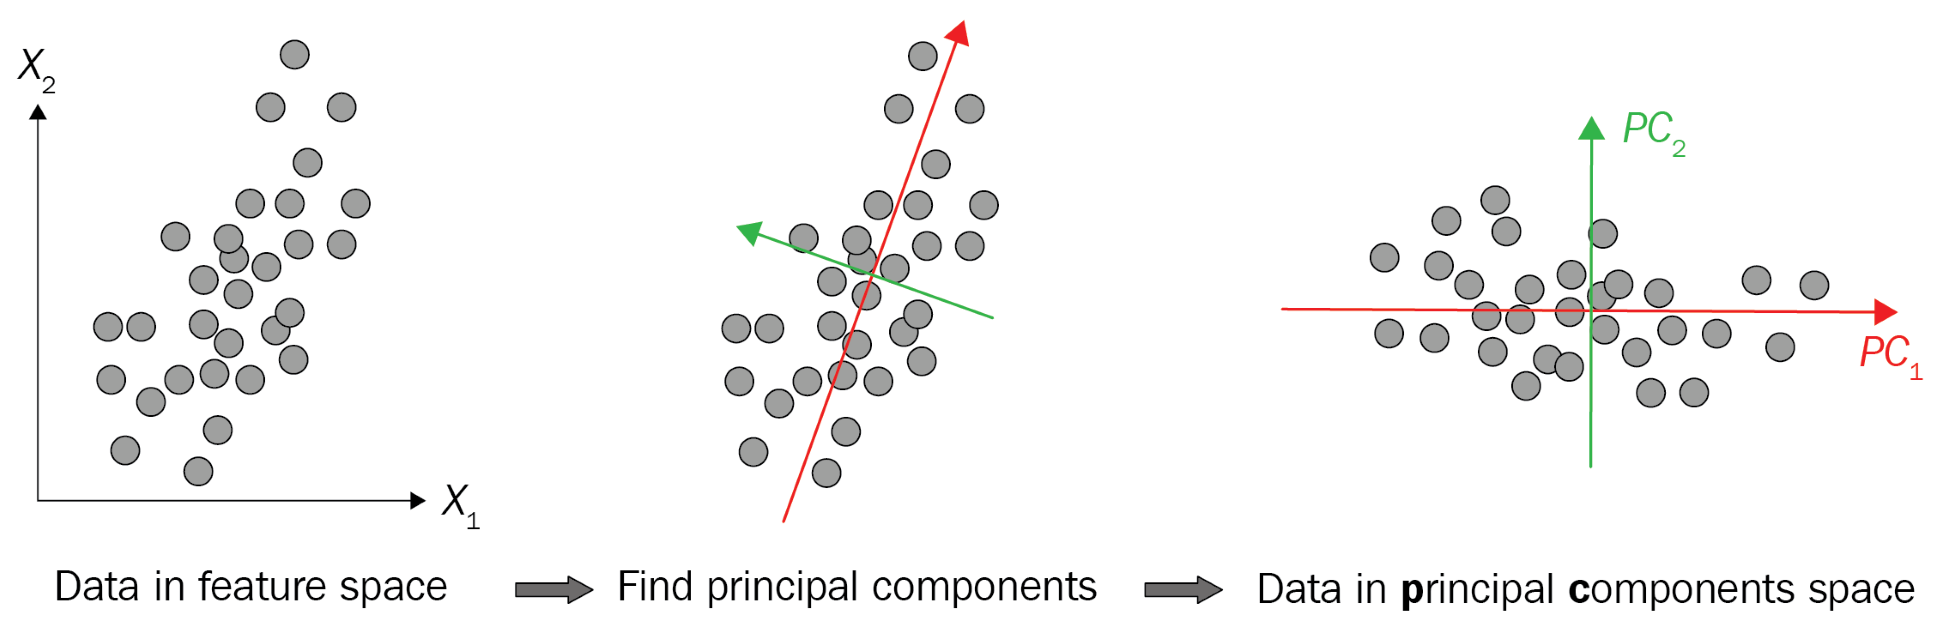

#### Example

We reduce dimensions and create “latent features” internally every day. 

* What does being "cool" mean?
    - we cannot directly measure "how cool" someone is
    - we internally *map* or *reduce* several different patterns of behavior to the one dimension of "coolness" 
* "Coolness" is an example of a latent feature:
 - it is **unobserved** and **not measurable directly**
 - it is, in some sense, a **combination** of many observable features
 - we implicitly *weigh* in our mind those observables and reduce them to a single **principal feature**

#### Singular Value Decomposition (SVD)

The following pieces of code apply SVD to extract a low-dimensional representation for the data.

SVD relies on the assumption that:
- few pieces of data contain most of the *information* in our dataset
- the rest of the data is irrelevant and can be treated as *noise*

The reduction is based on a **decomposition** of the original matrix:

<img src="SVD.png" alt="SVD" width="500"/>

$\Sigma$ is a (sorted) **diagonal** matrix, and the magnitude of the diagonal elements of $\Sigma$ measure the *importance* of the corresponding dimensions.

The light gray areas show the original data, and the **dark gray** areas show the **only data** used in the **matrix approximation**.

In [28]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(prod_matrix.to_numpy(), n_components = min(prod_matrix.shape) )

# ** NOTE ** 
#
# randomized_svd()
#   Computes a truncated randomized SVD.
#
# We set -- n_components = min(prod_matrix.shape) -- because we do not know
# yet how many components/dimensions we want to keep. We keep all of them.
# Sigma is a diagonal matrix, it contains at most min(m,n) singolar values.
#
# ** NOTE ** 

The **energy** of the system is measured by the sum of the square of the elements on the diagonal of $\Sigma$.
You typically want to keep 90% of the energy, so the number of dimensions is chosen by adding squared diagonal elements until you reach 90% of the total.

In [29]:
Sigma2=Sigma**2
print(f"Tot Energy: {sum(Sigma2)}")
print(f"90%: {sum(Sigma2)*0.9}")

#
# We use the following function to select the number of dimensions to keep
# 

def get_number_of_dimensions_to_keep( S, max_d ):
    S2 = S**2
    energy_90 = sum(S2)*0.9
    for i in range(max_d):
        if sum(S2[:i]) >= energy_90:
            return i
    return max_d

n_comp = get_number_of_dimensions_to_keep(Sigma,prod_matrix.shape[0])
print(f"Number of components: {n_comp}")

Tot Energy: 382923.9999999998
90%: 344631.59999999986
Number of components: 405


We now compute the **approximated matrix** to be used for our recommender system.

In [30]:
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=n_comp)
reduced_matrix = SVD.fit_transform(prod_matrix)

print(f"Original matrix: {prod_matrix.shape}")
print(f"Approximation: {reduced_matrix.shape}")

Original matrix: (1398, 19101)
Approximation: (1398, 405)


#### Exercise:

Replicate item-based filtering with the reduced matrix.

__________________
__________________

## Association Rules Mining

Another way to come up with recommendations is looking for **association rules** of the form $\{A\} \implies \{B\}$, that is, an interest in item $A$ *implies* an interest in item $B$ (or, more generally, $\{A_1,\ldots,A_n\} \implies \{B\}$).

### Apriori Algorithm

The first step is mining **frequent itemsets**. This can be done using the **apriori** algorithm.

Apriori uses a "bottom up" approach:
- define a minimum occurrence threshold
- identify individual items that satisfy the threshold
- extend the itemset, adding one item at a time and checking if the resulting set still satisfies the threshold

The algorithm stops when there are no more items to add that meet the minimum occurrence requirement.

Here is an example of apriori in action, assuming a minimum occurence threshold of 3:

```
Orders:
1. apple, egg, milk
2. carrot, milk  
3. apple, egg, carrot
4. apple, egg
5. apple, carrot


Iteration 1: Count the number of times each item occurs   
```

|item set|occurrence count|
|:--|--:|
|{apple}|              4 |   
|{egg}|                3 |   
|{milk}|               2 |  
|{carrot}|             2 |  

```
{milk} and {carrot} are eliminated because they do not meet the minimum occurrence threshold.

Iteration 2: Build item sets of size 2 using the remaining items from Iteration 1 
```

|item set|occurence count|
|:--|--:|
|{apple, egg}|         3 | 

```
The set {apple, egg} satisfies the threshold. The algorithm stops since there are no more items to add.
```

Once the item sets have been generated using apriori, we can start mining association rules. 

For the sake of simplicity, we will only look at itemsets of size 2 and at association rules of the form $\{A\} \implies \{B\}$.
In recommendation systems, this is often used to derive suggestions like "customers who bought $A$ also bought $B$".

There are 3 key **metrics** to consider when evaluating association rules, that correspond to  basic concepts of probability and (Bayesian) statistics.

### Support

This is the percentage of orders that contains the item set.
In the example above, there are 5 orders in total and {apple,egg} occurs in 3 of them, so:

```
support({apple,egg}) = 3/5 or 60%
```

The minimum support threshold required by apriori can be set based on domain knowledge.
In a grocery dataset, since there could be thousands of distinct items and an order can contain only a small fraction of these items, a support threshold to 0.01% may be reasonable.

### Confidence

Given two items, $A$ and $B$, the confidence measures the percentage of times that item $B$ is purchased, *given* that item $A$ was purchased.
This is expressed as:

```
confidence({A}->{B}) = support({A,B})/ support({A})


**Q1: what is the range of confidence({A}->{B})?**

**Q2: what probabilistic quantity does confidence({A}->{B}) measure?**

**Q3: is confidence({A}->{B}) equal to confidence({B}->{A})?**

In our example:

```
confidence{apple->egg} = support{apple,egg} / support{apple} = 0.75 or 75%
```

This is the percentage of times that egg is purchased, given that apple was purchased.

### Lift

Given two items, $A$ and $B$, the lift indicates whether there seems to be a relationship between $A$ and $B$, or whether these two items occur together in the same orders by chance:

```
lift({A,B}) = support({A,B}) / (support({A}) * support({B}))
```

**Q1: what is the range of lift({A,B})?**

**Q2: what is the probabilistic interpretation of lift({A,B})?**

**Q3: is lift({A,B}) equal to lift({B,A})?**

In our example, we compute lift as follows:

```
lift({apple,egg}) = support({apple,egg}) / (support({apple}) * support({egg})) = 1.25
```

The numerator is the probability that an order includes both apples and eggs, while the denominator is the same probability *if* the two events (buying apples and buying eggs) were **independent**.

In summary:
 * lift = 1 implies no relationship between $A$ and $B$.

 * lift > 1 implies that there is a positive relationship between $A$ and $B$.

 * lift < 1 implies that there is a negative relationship between $A$ and $B$.
   

### Case Study: Instacart purchases

Instacart, an online grocer, has made some of their datasets accessible to the public, as part of an online competition, at https://www.kaggle.com/competitions/instacart-market-basket-analysis/data.

We will consider a dataset composed of a list of orders (and reorders).

In [31]:
import pandas as pd

#### Part 1: Data Preparation

Load order data:

In [32]:
orders = pd.read_csv('order_products.csv')
orders.head()

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

In [33]:
orders.shape

(1000000, 4)

In [34]:
num_orders = orders['order_id'].nunique()

In [35]:
num_orders

99260

We drop the last 2 columns and rename products to items:

In [36]:
orders.drop(columns=['add_to_cart_order','reordered'], inplace=True)
orders.rename(columns={'product_id':'item_id'}, inplace=True)
orders.head()

order_id  item_id
0         2    33120
1         2    28985
2         2     9327
3         2    45918
4         2    30035

#### Part 2: Frequent Itemsets 

In [37]:
# set the threshold
min_support = 0.01
print(f"Starting with {len(orders)} rows!")

Starting with 1000000 rows!


In [38]:
# compute the frequency of each item as a dataframe indexed by the item id
item_stats = orders.groupby('item_id').count()
item_stats.rename(columns={'order_id':"freq"}, inplace=True)
# add a column with the support
item_stats['support'] = item_stats['freq']/num_orders*100

In [39]:
item_stats.head()

freq   support
item_id                
1          59  0.059440
2           3  0.003022
3           3  0.003022
4          10  0.010075
8           2  0.002015

In [40]:
# filter items below min support 
qualifying_items = item_stats[item_stats['support'] >= min_support].index
orders = orders.loc[orders['item_id'].isin(qualifying_items)]

In [41]:
print(f"Items with support >= {min_support}: {len(qualifying_items)}")
print(f"Remaining rows: {len(orders)}")

Items with support >= 0.01: 11325
Remaining rows: 927649


In [42]:
# drop all orders with less than 2 items
order_size = orders.groupby('order_id').count()
order_size.rename(columns={'item_id':"size"}, inplace=True)
qualifying_orders = order_size[order_size['size']>=2].index
orders = orders.loc[orders['order_id'].isin(qualifying_orders)]

In [43]:
print(f"Remaining orders with 2+ items: {len(qualifying_orders)}")
print(f"Remaining rows: {len(orders)}")

Remaining orders with 2+ items: 93142
Remaining rows: 922075


In [44]:
# recompute the frequency of each item as a dataframe indexed by the item id
item_stats = orders.groupby('item_id').count()
item_stats.rename(columns={'order_id':"freq"}, inplace=True)
# add a column with the support
num_remaining_orders = orders['order_id'].nunique()
item_stats['support'] = item_stats['freq']/num_remaining_orders*100

In [45]:
item_stats.head()

freq   support
item_id                
1          57  0.061197
4          10  0.010736
10         62  0.066565
12         12  0.012884
23         32  0.034356

In [46]:
# import a function that compute all combinations from a sequence 
from itertools import combinations

In [47]:
# group items in the same order
groups = orders.groupby('order_id').agg({'item_id':list})
# for each order, get all item pairs and update the counter for that pair
item_pairs = {}
for items in groups['item_id']:
    for pair in combinations(items,2):
        if pair in item_pairs:
            item_pairs[pair] += 1
        else:
            item_pairs[pair] = 1
# get a DataFrame with the frequency of each pair and the support
item_pairs = pd.DataFrame({'item_A':[p[0] for p in item_pairs.keys()], 'item_B':[p[1] for p in item_pairs.keys()], 'freq':item_pairs.values()})
num_remaining_orders = orders['order_id'].nunique()
item_pairs['support'] = item_pairs['freq']/num_remaining_orders*100

In [48]:
item_pairs.head()

item_A  item_B  freq   support
0   33120   28985    10  0.010736
1   33120    9327     1  0.001074
2   33120   45918     1  0.001074
3   33120   30035     1  0.001074
4   33120   17794     9  0.009663

In [49]:
print(f"Item pairs: {len(item_pairs)}")

Item pairs: 3672671


In [50]:
# Filter the item_pairs below min support
item_pairs = item_pairs[item_pairs['support'] >= min_support]

In [51]:
print(f"Item pairs with support >= {min_support}: {len(item_pairs)}")

Item pairs with support >= 0.01: 51856


In [52]:
# Merge all in the same DataFrame
item_pairs = item_pairs.merge(item_stats.reset_index().rename(columns={'item_id':'item_A', 'freq':'freq_A', 'support':'support_A'}))
item_pairs = item_pairs.merge(item_stats.reset_index().rename(columns={'item_id':'item_B', 'freq':'freq_B', 'support':'support_B'}))

In [53]:
item_pairs.head()

item_A  item_B  freq   support  freq_A  support_A  freq_B  support_B
0   33120   28985    10  0.010736     623   0.668871    2091   2.244959
1   33754   28985    15  0.016104     952   1.022095    2091   2.244959
2   24838   28985    21  0.022546    1516   1.627622    2091   2.244959
3   21903   28985   226  0.242640    7430   7.977067    2091   2.244959
4   46667   28985    50  0.053681    1649   1.770415    2091   2.244959

#### Part 3: Association Rules Mining

In [54]:
# Compute relevant metrics
item_pairs['confidenceAtoB'] = item_pairs['support'] / item_pairs['support_A']
item_pairs['confidenceBtoA'] = item_pairs['support'] / item_pairs['support_B']
item_pairs['lift']           = item_pairs['support'] / (item_pairs['support_A'] * item_pairs['support_B']) 
# Sort by lift in descending order
item_pairs = item_pairs.sort_values('lift', ascending=False)

In [55]:
# Replace item id with item name and display association rules
item_name   = pd.read_csv('products.csv')
item_name   = item_name.drop(columns=['aisle_id','department_id'])
item_pairs  = item_pairs.merge(item_name.rename(columns={'product_id':'item_A','product_name':'name_A'}))
item_pairs  = item_pairs.merge(item_name.rename(columns={'product_id':'item_B','product_name':'name_B'}))
rules_final = item_pairs.sort_values('lift', ascending=False)

In [56]:
rules_final = rules_final[['name_A','name_B','lift','confidenceAtoB','confidenceBtoA']]

In [57]:
rules_final

name_A  \
0                   Gobble Gobble Turkey Pouch Stage 3   
1             Antioxidant Infusions Brasilia Blueberry   
2               Cream on Top Strawberry Organic Yogurt   
3     Organic Strawberry Chia Lowfat 2% Cottage Cheese   
4                       Tender Chicken & Stars Stage 3   
...                                                ...   
360                                       Strawberries   
3793                                   Organic Avocado   
8041                              Organic Hass Avocado   
1567                                            Banana   
2637                            Bag of Organic Bananas   

                                                 name_B       lift  \
0     Stage 3 Hearty Meals - Chick Chick Organic Bab...  10.705977   
1           Antioxidant Infusions Costa Rica Clementine   9.131569   
2      Organic Blueberry Cream On Top Whole Milk Yogurt   8.913110   
3            Organic Cottage Cheese Blueberry Acai Chia   8.624259   
4     Organic Spring Vegetables & Pasta Stage 3 Baby...   8.213580   
...                                                 ...        ...   
360                                Organic Strawberries   0.000608   
3793                               Organic Hass Avocado   0.000319   
8041                                    Organic Avocado   0.000292   
1567                             Bag of Organic Bananas   0.000129   
2637                                             Banana   0.000086   

      confidenceAtoB  confidenceBtoA  
0           0.379310        0.333333  
1           0.333333        0.323529  
2           0.315789        0.363636  
3           0.250000        0.370370  
4           0.185185        0.476190  
...              ...             ...  
360         0.005285        0.002841  
3793        0.002235        0.001836  
8041        0.001683        0.002049  
1567        0.001634        0.002037  
2637        0.001358        0.001089  

[51856 rows x 5 columns]

#### Part 4: Conclusion

We see that many associations are not surprising (same product in different "packaging" or different flavor).

However, we can explore the rules better to find something less obvious:

In [58]:
rules_final[rules_final['name_A']=='Banana']

name_A                                            name_B      lift  \
50601  Banana  Mixed Berries Wildly Nutritious Signature Blends  0.034771   
50602  Banana                                    Shredded Wheat  0.028820   
50603  Banana                    All Natural Whole Strawberries  0.027174   
50604  Banana              Original Deli Style Pretzel Crackers  0.027174   
50605  Banana                          Berry Valley Blueberries  0.026237   
...       ...                                               ...       ...   
45690  Banana                      Organic Whole Grassmilk Milk  0.002745   
15408  Banana                                              Soda  0.002247   
30465  Banana                    Organic Extra Virgin Olive Oil  0.001821   
27883  Banana                                   Sparkling Water  0.001752   
1567   Banana                            Bag of Organic Bananas  0.000129   

       confidenceAtoB  confidenceBtoA  
50601        0.001157        0.548387  
50602        0.000681        0.454545  
50603        0.001021        0.428571  
50604        0.001021        0.428571  
50605        0.000817        0.413793  
...               ...             ...  
45690        0.001361        0.043290  
15408        0.002519        0.035441  
30465        0.000749        0.028721  
27883        0.000681        0.027624  
1567         0.001634        0.002037  

[2535 rows x 5 columns]

In [59]:
rules_final.sort_values(by='confidenceAtoB', ascending=False)

name_A  \
9          Chunky Blend Vegetable Beef Pilaf Baby Food   
0                   Gobble Gobble Turkey Pouch Stage 3   
39     Unsweetened Whole Milk Mixed Berry Greek Yogurt   
40            Unsweetened Whole Milk Strawberry Yogurt   
50            0% Greek, Blueberry on the Bottom Yogurt   
...                                                ...   
50670                                           Banana   
51030                                           Banana   
50671                                           Banana   
3217                                            Banana   
51358                                           Banana   

                                                  name_B       lift  \
9                         Tender Chicken & Stars Stage 3   7.186883   
0      Stage 3 Hearty Meals - Chick Chick Organic Bab...  10.705977   
39         Unsweetened Whole Milk Blueberry Greek Yogurt   5.756988   
40         Unsweetened Whole Milk Blueberry Greek Yogurt   5.667870   
50     Nonfat Strawberry With Fruit On The Bottom Gre...   5.669223   
...                                                  ...        ...   
50670                      Organic Elmo Noodlemania Soup   0.017613   
51030  Family Size Shells & White Cheddar Macaroni & ...   0.011528   
50671                          Apple & Apricot Fruit Bar   0.017613   
3217                Honey Almond Flax Chewy Granola Bars   0.011528   
51358                            Purified Drinking Water   0.009058   

       confidenceAtoB  confidenceBtoA  
9            0.416667        0.185185  
0            0.379310        0.333333  
39           0.358491        0.327586  
40           0.352941        0.413793  
50           0.346939        0.298246  
...               ...             ...  
50670        0.000681        0.277778  
51030        0.000681        0.181818  
50671        0.000681        0.277778  
3217         0.000681        0.181818  
51358        0.000681        0.142857  

[51856 rows x 5 columns]